In [1]:
%matplotlib inline

In [2]:
from rayoptics.environment import *
from rayoptics.seq import medium    # shortcut reference to medium package

In [3]:
isdark = False

In [4]:
opm = OpticalModel()
sm = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']
em = opm['ele_model']
pt = opm['part_tree']
ar = opm['analysis_results']   # add analysis results model for paraxial data

In [5]:
osp['pupil'] = PupilSpec(osp, key=['object', 'pupil'], value=3)
osp['fov'] = FieldSpec(osp, key=['object', 'angle'], value=5.0, flds=[0.],is_relative=True)
osp['wvls'] = WvlSpec([(546.074, 1.0)], ref_wl=0)

opm.radius_mode = True

## 1) Model with constant index materials

### Creating a model with constant index materials

The add_surface() fct can't easily be used to create a constant refractive index material.
Use the index and a "fake" V-number to satisfy add_surface().
Then directly create and assign the constant index Medium to the appropriate gaps.

In [6]:
sm.gaps[0].thi=1e10
sm.add_surface([7.77, 0.55, 1.376, 56., 5.])
sm.gaps[sm.cur_surface].medium = medium.Medium(1.376, 'Medium1')
sm.add_surface([6.8, 3.4, 1.336, 56., 5.])
sm.gaps[sm.cur_surface].medium = med2 = medium.Medium(1.336, 'Medium2')
sm.add_surface([0., 1.6, 1.336, 56., 3.])
sm.gaps[sm.cur_surface].medium = med2
sm.set_stop()
sm.add_surface([20., 0.7, 1.5, 56., 3.])
sm.gaps[sm.cur_surface].medium = medium.Medium(1.5, 'Medium3')
sm.add_surface([-20., 21., 1.336, 56., 3.])
sm.gaps[sm.cur_surface].medium = med2
sm.add_surface([0., 0.])
sm.ifcs[sm.cur_surface].max_aperture = 3.
sm.ifcs[-1].max_aperture = 3.

In [7]:
sm.do_apertures = False
opm.update_model()
sm.list_model()

              r            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+10       air             1      1.0000
    1:     7.770000     0.550000   Medium1             1      5.0000
    2:     6.800000      3.40000   Medium2             1      5.0000
 Stop:     0.000000      1.60000   Medium2             1      3.0000
    4:    20.000000     0.700000   Medium3             1      3.0000
    5:   -20.000000      21.0000   Medium2             1      3.0000
    6:     0.000000      0.00000       air             1      3.0000
  Img:     0.000000      0.00000                       1      3.0000


## 2) Setting pupil size based on the stop size

### Use set_vignetting
The set_vignetting function ensures the bundle defining rays at each field point pass thru the edge of the most limiting aperture in the model. In this case the stop surface is the limiting aperture.

In [8]:
set_vignetting(opm)

### Negative vignetting means rays overfill pupil to fill stop
Listing the object properties for the field points shows negative vignetting values. This means the entrance pupil is undersized and the vignetting is overfilling the pupil to fill the aperture stop.

In [9]:
listobj(osp['pupil'])
listobj(osp['fov'])

aperture: object pupil; value=3

field: object angle; value=0.0
x,y=0.0 vlx=-1.253 vux=-1.253 vly=-1.253 vuy=-1.253



### Marginal ray trace
Trace the marginal ray for the axial field point.

In [10]:
fi = 0
fld, wvl, foc = osp.lookup_fld_wvl_focus(fi)

pupil = [0., 1.]
ray01, ray_op01, wvl = trace_base(opm, pupil, fld, wvl)
list_ray(ray01)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000            0     0.000000     0.000000     1.000000        1e+10
  1:      0.00000      3.37918      0.77329     0.000000    -0.128001     0.991774      0.63518
  2:      0.00000      3.29788      0.85324     0.000000    -0.116173     0.993229       2.5641
  3:      0.00000      3.00000            0     0.000000    -0.116173     0.993229       1.8078
  4:      0.00000      2.78998      0.19556     0.000000    -0.118727     0.992927      0.31638
  5:      0.00000      2.75242      -0.1903     0.000000    -0.150843     0.988558       21.436
  6:      0.00000     -0.48100            0     0.000000    -0.201527     0.979483            0
  7:      0.00000     -0.48100            0     0.000000    -0.201527     0.979483            0


### Revise entrance pupil diameter
Get the ray height on the first surface. For an infinite object, this is the pupil radius.

In [11]:
rs1 = RaySeg(*ray01[1])
epd = 2*abs(rs1.p[1])
epd

6.758369049845509

In [12]:
osp['pupil'].value = epd

In [13]:
opm.update_model()

In [14]:
listobj(osp['fov'])

field: object angle; value=0.0
x,y=0.0 vlx=-1.253 vux=-1.253 vly=-1.253 vuy=-1.253



### Finish pupil redefinition
The pupil size has been redefined so the vignetting needs to be updated as well. The values to overfill the pupil are still in place. set_vignetting can fix this up.

In [15]:
set_vignetting(opm)

In [16]:
listobj(osp['pupil'])
listobj(osp['fov'])

aperture: object pupil; value=6.758369049845509

field: object angle; value=0.0
x,y=0.0 vlx=-0.000 vux=-0.000 vly=-0.000 vuy=-0.000



### Lens layout
The lens layout doesn't look too bad. It considers the model to be a set of cemented elements for the purposes of drawing a picture.

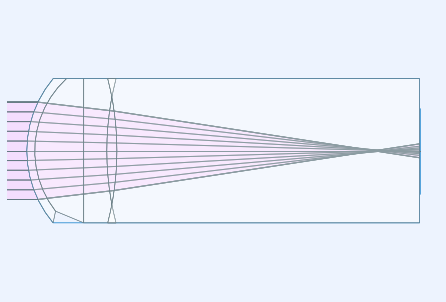

In [17]:
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm,
                        do_draw_rays=True, do_draw_ray_fans=True, do_paraxial_layout=False, is_dark=isdark).plot()

## 3) Longitudinal spherical aberration

### Calculation approach

The general approach to calculating longitudinal spherical would be to:

1) get the ray data at the image plane

In [18]:
img_seg = RaySeg(*ray01[-1])

In [19]:
img_seg.p, img_seg.d

(array([ 0.        , -0.48099593,  0.        ]),
 array([ 0.        , -0.20152687,  0.97948299]))

2) divide the ray height at the image plane by the ray direction tangent.

3) I assume negative means inward from the image plane for LSA

In [20]:
LSA = -img_seg.p[1]/(img_seg.d[1]/img_seg.d[2])
LSA

-2.337789122532606

In [21]:
efl = ar['parax_data'].fod.efl

In [22]:
corrected_efl = efl + LSA/2
efl, corrected_efl

(17.888918967654664, 16.72002440638836)

In [23]:
pm.list_model()

           ax_ht        pr_ht       ax_slp       pr_slp         power          tau        index    type
 0:            0 -1.74551e+08  3.37918e-10    0.0174551             0        1e+10      1.00000    dummy
 1:      3.37918   -0.0590504    -0.163523    0.0203126    0.04839125     0.399709      1.37600    transmit
 2:      3.31382   -0.0509313     -0.14403     0.020013  -0.005882353      2.54491      1.33600    transmit
 3:      2.94728  1.31406e-08     -0.14403     0.020013             0       1.1976      1.33600    transmit
 4:      2.77479    0.0239677    -0.166783    0.0198165        0.0082     0.466667      1.50000    transmit
 5:      2.69696    0.0332153    -0.188898    0.0195441        0.0082      15.7186      1.33600    transmit
 6:    -0.272251      0.34042    -0.188898    0.0195441            -0            0      1.00000    transmit
 7:    -0.272251      0.34042    -0.188898    0.0195441             0            0      1.00000    dummy


In [24]:
pm.first_order_data()

efl               17.89
ffl              -16.65
pp1               1.242
bfl              -1.441
ppk               19.33
f/#               2.647
m            -1.789e-09
red           -5.59e+08
obj_dist          1e+10
obj_ang               1
enp_dist          3.383
enp_radius        3.379
na obj        3.379e-10
n obj                 1
img_dist         -1.441
img_ht           0.3123
exp_dist         -18.86
exp_radius        3.018
na img          -0.1856
n img                 1
optical invariant      0.05898


## Longitudinal Spherical Aberration plot

### Trace the rays

Use the RayFan primitive to easily trace a fan of rays across the pupil.

In [25]:
ray_fan = analyses.RayFan(opm, f=fld, wl=wvl, xyfan='y')

In [26]:
ray_list, _ = ray_fan.fan_pkg

### Postprocess the ray fan

Loop over the rays and calculate the LSA for each rays

In [27]:
x = []
y = []
for r in ray_list:
    px, py, rs = r
    ray, _, _ = rs
    img = ray[-1]
    lsa = -img.p[1]/(img.d[1]/img.d[2])
    x.append(lsa)
    y.append(ray[3].p[1])  # stop surface ray height

### Plot using Matplotlib

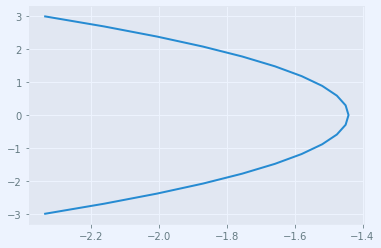

In [28]:
plt.plot(x,y)

### shift image plane to paraxial focus

In [29]:
ax_ray = ar['parax_data'].ax_ray

In [30]:
prx_img_dist = -ax_ray[-1][mc.ht]/ax_ray[-1][mc.slp]
prx_img_dist

-1.441260012176454